<div style="background-color:#035FCA; color:#19180F; font-size:40px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> CTRL(Conditional Transformer Language Model) </div>

<div style="background-color:#568FD1; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">🔧Architecture Overview⚙️
 </div>
<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
It is a language model architecture designed to generate human like text based on a given control code or prompt. It combines the power of transformers with the ability to condition the model's output based on specific instructions.<br>

The architecture of CTRL consists of various building blocks which are explained below<br>

1. Input Encoding : The input text is first tokenized. These tokens capture the meaning & structure of the text. Each token is then converted into a high dimensional vector representation.<br>

2. Transformer Encoder - The encoded input tokens are passed through multiple layers of transformer encoders. Each encoder layer consists of two sub layers - A multi headed self attn mechanism and a position wise feedfwd neural network. The self attn mechanism helps the model capture dependencies between diff words in the i/p whereas the feed forward network applies non linear transformations to each position in the sequence.<br>

3. Control code embedding : CTRL introduces an additional control code embedding to allow conditioning the model's output on specific instructions. The control code is appenedd to the input tokens and has its own learned embedding representations. This enables fine grained control over the generated text.<br>

4. Transformer Decoder : The output of the control code embedding is passed through a series of transformer decoder layers. Each decoder layer also consists of self attn and feed forward sub layers. The decoder layers refine the representation of the control code and generate the final output tokens.<br>

5. Output decoding - The decoder's o/p tokens are decoded to generate the final text. The decoding process involves converting the token representations back into text.<br>


<b>Architectural differences w.r.t ELECTRA, ALBERT, BERT, RoBERTa, GPT2, XLNet and T5</b><br>

- Controlled Generation - CTRL is specifically designed for controlled text generation where a control code or prompt guides the output. It allows users to specify the desired style, topic or other attributes of the generated text.<br>

- Bidirectionality - Unlike models like GPT2 and XLNet, which are unidirectional llms, CTRL is bidirectional i.e It can utilize both the left and right contexts of a token to generate its representations. This allows the model to have a better understanding of the dependencies within the text like Bidirectional LSTM does.<br>

- Control code conditioning - It introduces control code embedding which is a unique component in its architecture. It enables the model to condition its output based on the given control code making it highly flexible for various language generation tasks.<br>

- Diff pretraining objective- UNlike ELECTRA and BERT which employs MLM as their pretraining objective, CTRL employs a new objective called "relevance ranking" which involves compairing different parts of the input text to identify the most relevant content.<br>

- Domain adaptation - CTRL supports domain adaptation, allowing fine tuning of the model on specific domains or datasets. This improves the model's performance and adaptability for particular applications.<br>

<div style="background-color:#568FD1; color:#19180F; font-size:30px; font-family:Verdana; padding:10px; border: 5px solid #19180F;"> 🏢 Architecture Diagram.
 </div>
<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">

1. Input: This is the text that is entered into the CTRL Transformer architecture.<br>

2. Tokenization: The tokenizer performs the tokenization procedure on the supplied text. Tokenization divides the input text into individual tokens, which are the basic units of input for the language model.<br>

3. Encoder: The essential component of the CTRL Transformer design is the encoder. It is made up of many encoder blocks, each of which is responsible for processing a piece of the input text. Four encoder blocks are presented in pairs in this figure.<br>

4. Encoder Blocks: The encoder blocks take the tokenized input text and conduct different actions on it in order to capture the tokens' contextual information. Each encoder block has a number of components that are shared by the pairings.<br>

5. Encoder Components: The following are the major components found in each encoder block:<br>
   - Self-Attention: This component enables the model to focus on various segments of the input sequence while taking into account token connections.<br>
   - Multi-Head Attention: It expands self-attention by attending to and mixing distinct representations (heads) of the information.<br>
   - Feed-Forward Network: This component processes attended representations and extracts higher-level features using a collection of fully linked layers.<br>
   - Residual Connection: It improves information flow by connecting the feed-forward network's output to the encoder block's input.<br>
   - Layer Normalisation: This component normalises the encoder block's output, assisting in the stabilisation of the training process.<br>

6. Connections: The connections between the parts show how information and data move across the encoder blocks. The data transmission direction is shown by the arrows.<br>

7. Output: The processed representations go to the last layer normalisation component after passing via the encoder blocks, where they produce the output text.<br>

The illustration shows the process by which the input text is tokenized, then processed by the encoder blocks with their corresponding components, and ultimately turned into the output text.<br>
</div>


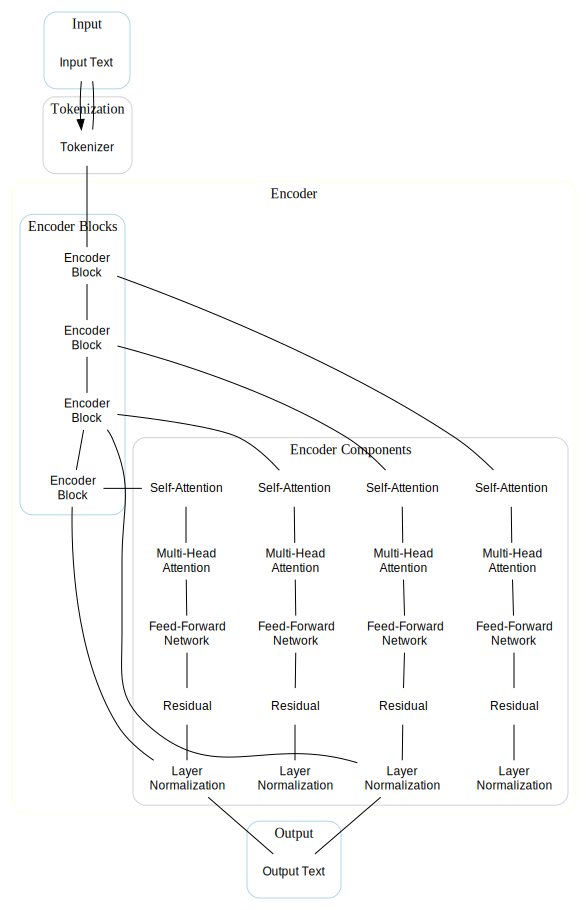

In [1]:
from IPython.display import SVG, display

# Load the SVG file and display it
svg_file = '/kaggle/input/notebook-images/ctrl.svg'
display(SVG(filename=svg_file))

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
This code snippet imports the necessary libraries.</div>

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import CTRLConfig, CTRLLMHeadModel, CTRLTokenizer, CTRLForSequenceClassification, AdamW

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Defining the path to train.csv and train folder</div>

In [3]:
train_csv_path = '/kaggle/input/landmark-recognition-2021/train.csv'
train_folder_path = '/kaggle/input/landmark-recognition-2021/train/'


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
The code snippet reads a CSV file (`train_csv_path`) using pandas' `read_csv` function and stores the data in a DataFrame called `train_df`. The DataFrame represents a dataset containing information about images, including their IDs and corresponding image paths.<br>

The next line modifies the `image_path` column in the `train_df` DataFrame. It concatenates the `train_folder_path` (the base directory for the training images) with the subdirectories based on the ID of each image. The `train_df['id'].str[0]` extracts the first character of the ID, `train_df['id'].str[1]` extracts the second character, `train_df['id'].str[2]` extracts the third character, and `train_df['id']` represents the full ID. These components are concatenated using '/' as separators, and the '.jpg' extension is added at the end to form the complete image path for each image in the dataset.<br></div>


In [4]:
train_df = pd.read_csv(train_csv_path)
# Modify image_path column to match the directory structure
train_df['image_path'] = train_folder_path + train_df['id'].str[0] + '/' + train_df['id'].str[1] + '/' + train_df['id'].str[2] + '/' + train_df['id'] + '.jpg'


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Performing sanity check of the dataframe's image_path column</div>

In [5]:
train_df['image_path'][0]

'/kaggle/input/landmark-recognition-2021/train/1/7/6/17660ef415d37059.jpg'

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Splitting the modified dataframe into train and val data</div>

In [6]:
train_data, val_data = train_test_split(train_df, test_size=0.2, random_state=42)

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
The code snippet defines a series of image transformations using `torchvision.transforms.Compose`. These transformations are applied to each image in order to preprocess them before feeding them into a neural network model for training or inference.<br>

The transformations specified in `image_transforms` are as follows:<br>

1. `transforms.Resize((224, 224))`: Resizes the input image to a fixed size of 224x224 pixels. This is a common size used in many computer vision models.<br>

2. `transforms.ToTensor()`: Converts the image from PIL Image format to a PyTorch tensor. This allows the image to be processed by PyTorch and passed through neural networks.<br>

3. `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`: Normalizes the tensor image by subtracting the mean values `[0.485, 0.456, 0.406]` from each channel and dividing by the standard deviation values `[0.229, 0.224, 0.225]`. Normalization helps in standardizing the pixel values across images and improves model performance.<br></div>


In [7]:
image_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
The code snippet defines a custom dataset class called `LandmarkDataset`. This class inherits from `torch.utils.data.Dataset`, which is a PyTorch base class for creating custom datasets.<br>

The `LandmarkDataset` class has the following methods:<br>

1. `__init__(self, data, transform=None)`: The initialization method takes two parameters: `data` and `transform`. The `data` parameter represents the dataset, typically a DataFrame containing information about the images. The `transform` parameter is an optional parameter that represents the image transformations to be applied to each image. These transformations are defined earlier using `transforms.Compose`.<br>

2. `__len__(self)`: This method returns the length of the dataset, i.e., the total number of samples in the dataset.<br>

3. `__getitem__(self, index)`: This method retrieves an item from the dataset at the specified `index`. It first retrieves the image path corresponding to the given index from the dataset. Then, it opens the image using `PIL.Image.open` and converts it to the RGB mode using `.convert('RGB')`. This ensures that the image has three channels (red, green, and blue) required by most deep learning models.<br>

   If a transformation is specified (`self.transform is not None`), it applies the transformation to the image using `self.transform(image)`. The transformed image is then returned.<br>

   Finally, the method returns the image as the output.<br></div>


In [8]:
class LandmarkDataset(torch.utils.data.Dataset):
    def __init__(self, data, transform=None):
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image_path = self.data.iloc[index]['image_path']
        image = Image.open(image_path).convert('RGB')

        if self.transform is not None:
            image = self.transform(image)

        return image


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Creating train and val dataset using the train, val splits of the data.</div>

In [9]:
# Create DataLoader objects for training and validation data
train_dataset = LandmarkDataset(train_data, transform=image_transforms)
val_dataset = LandmarkDataset(val_data, transform=image_transforms)


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Creating dataloaders using the train and val dataset</div>

In [10]:
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1)

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Altering the configuration file of CTRL as per our need.</div>

In [11]:
config = CTRLConfig.from_pretrained('ctrl')
config.num_labels = 1  # Number of output labels (landmark or not)


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">

The code snippet defines a custom model called `CustomCTRLModel` that extends the `CTRLForSequenceClassification` class from the Transformers library.<br>

1. `class CustomCTRLModel(CTRLForSequenceClassification)`: This line defines the `CustomCTRLModel` class that inherits from `CTRLForSequenceClassification`. This allows you to customize and extend the functionality of the base model.<br>

2. `def __init__(self, config)`: This is the constructor method of the custom model. It takes a `config` object as an argument, which contains the configuration parameters for the model. Inside the constructor, the `super().__init__(config)` line calls the constructor of the base class to initialize the model using the provided configuration.<br>

3. `self.image_embedding = nn.Linear(image_feature_size, config.hidden_size)`: This line creates a linear layer (`nn.Linear`) called `image_embedding`. It maps the `image_feature_size` to the `hidden_size` specified in the model's configuration.<br>

4. `self.fusion = nn.Linear(config.hidden_size+1, config.hidden_size)`: This line creates another linear layer called `fusion`. It takes as input the concatenation of the `hidden_size` of the text outputs and the size of the image embeddings plus 1 (to account for the additional dimension introduced by `unsqueeze`). The output size is set to `hidden_size`.<br>

5. `def forward(self, input_ids, inputs_embeds=None, image_embeds=None, **kwargs)`: This method defines the forward pass of the model. It takes input IDs, input embeddings, and image embeddings as arguments. The `**kwargs` parameter allows for additional keyword arguments that may be passed to the base model's forward method.<br>

6. `text_outputs = super().forward(input_ids=input_ids, inputs_embeds=inputs_embeds, **kwargs)`: This line calls the `forward` method of the base class (`CTRLForSequenceClassification`) with the provided arguments. It computes the text outputs of the model.<br>

7. `if image_embeds is not None:`: This conditional statement checks if image embeddings are provided as input.<br>

8. `image_outputs = self.image_embedding(image_embeds)`: If image embeddings are provided, this line passes the image embeddings through the `image_embedding` linear layer to obtain `image_outputs`.<br>

9. `combined_outputs = torch.cat((text_outputs[0], image_outputs.unsqueeze(0)), dim=1)`: This line concatenates the text outputs and the image outputs along the second dimension (`dim=1`). It uses `torch.cat` to concatenate the tensors. The image outputs are unsqueezed to add an additional dimension to match the shape of the text outputs.<br>

10. `fused_outputs = self.fusion(combined_outputs)`: This line passes the concatenated outputs through the `fusion` linear layer to obtain the final fused outputs.<br>

11. `return fused_outputs, text_outputs[1:]`: This line returns the fused outputs and the remaining text outputs (excluding the first element, which is the pooled output) as a tuple.<br>

12. `else: return fused_outputs`: If image embeddings are not provided, this line simply returns the fused outputs.<br>

This custom model allows for the fusion of text and image features by concatenating their outputs and passing them through a linear layer for further processing.<br></div>

In [12]:
import torch.nn as nn
image_feature_size = 2048
class CustomCTRLModel(CTRLForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        self.image_embedding = nn.Linear(image_feature_size, config.hidden_size)
        self.fusion = nn.Linear(config.hidden_size+1, config.hidden_size)

    def forward(self, input_ids, inputs_embeds=None, image_embeds=None, **kwargs):
        text_outputs = super().forward(input_ids=input_ids, inputs_embeds=inputs_embeds, **kwargs)

        if image_embeds is not None:
            image_outputs = self.image_embedding(image_embeds)
            #rint(text_outputs[0].shape, image_outputs.shape)
            combined_outputs = torch.cat((text_outputs[0], image_outputs.unsqueeze(0)), dim=1)
            fused_outputs = self.fusion(combined_outputs)
            return fused_outputs, text_outputs[1:]
        else:
            return fused_outputs


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Initialising the tokenizer of CTRL</div>

In [13]:
tokenizer = CTRLTokenizer.from_pretrained('ctrl')

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
The  code snippet demonstrates how to utilize multiple GPUs for training by using DataParallel in PyTorch.<br>

1. `model = CustomCTRLModel(config=config)`: This line creates an instance of the `CustomCTRLModel` by passing the configuration object `config` to its constructor. This assumes that you have already defined the model architecture and imported the necessary modules.<br>

2. `if torch.cuda.device_count() > 1:`: This conditional statement checks if there are multiple GPUs available for training. The `torch.cuda.device_count()` function returns the number of available GPUs.<br>

3. `model = DataParallel(model)`: If multiple GPUs are available, this line wraps the model with `DataParallel`. The `DataParallel` class is responsible for distributing the input batches across multiple GPUs and aggregating the gradients during backpropagation.<br>

4. `device = torch.device("cuda" if torch.cuda.is_available() else "cpu")`: This line selects the device for training. If a GPU is available, it sets the device to CUDA (`"cuda"`), otherwise, it sets it to CPU (`"cpu"`).<br>

5. `model.to(device)`: This line moves the model to the selected device. By calling the `to` method on the model and passing the device as an argument, the model's parameters and buffers are transferred to the specified device.<br>

After executing this code snippet, the `model` is ready to be trained using either a single GPU or multiple GPUs, depending on the availability in the kaggle kernel.<br></div>

In [14]:
import torch
import torch.nn as nn
from torch.nn.parallel import DataParallel

# Assuming you have already created your model
model = CustomCTRLModel(config=config)

# Check if multiple GPUs are available
if torch.cuda.device_count() > 1:
    # Create DataParallel model
    model = DataParallel(model)

# Move the model to the GPU(s)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

CustomCTRLModel(
  (transformer): CTRLModel(
    (w): Embedding(246534, 1280)
    (dropout): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-47): 48 x EncoderLayer(
        (multi_head_attention): MultiHeadAttention(
          (Wq): Linear(in_features=1280, out_features=1280, bias=True)
          (Wk): Linear(in_features=1280, out_features=1280, bias=True)
          (Wv): Linear(in_features=1280, out_features=1280, bias=True)
          (dense): Linear(in_features=1280, out_features=1280, bias=True)
        )
        (ffn): Sequential(
          (0): Linear(in_features=1280, out_features=8192, bias=True)
          (1): ReLU()
          (2): Linear(in_features=8192, out_features=1280, bias=True)
        )
        (layernorm1): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (layernorm2): LayerNorm((1280,), eps=1e-06, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
    (la

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
It creates an instance of the AdamW optimizer by passing the model parameters (`model.parameters()`) and the learning rate (`lr=1e-5`) to its constructor. The `model.parameters()` function returns an iterator over all the trainable parameters of the model.<br>

The AdamW optimizer is a variant of the Adam optimizer that incorporates weight decay regularization. It is commonly used in deep learning for optimizing neural networks.</div>


In [15]:
optimizer = AdamW(model.parameters(), lr=1e-5)


/opt/conda/lib/python3.10/site-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Checking the length of train_loader and val_loader to figure out the number of steps that will be needed to complete one epoch as per declared batch_size</div>

In [16]:
len(train_loader), len(val_loader)

(1264376, 316094)

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
The code snippet defines an image encoder using ResNet-50. The purpose of the image encoder is to extract image features from input images.
1. `class ImageEncoder:`: This defines a custom class called `ImageEncoder` for the image encoder.<br>

2. `def __init__(self):`: This is the constructor method of the `ImageEncoder` class. It initializes the ResNet-50 model (`self.resnet`) with pretrained weights and sets its fully connected layer (`self.resnet.fc`) to a `torch.nn.Identity()` layer, effectively removing the fully connected layer.<br>

3. `self.transform = transforms.Compose([...])`: This defines a sequence of image transformations to be applied to the input images. It includes resizing the images to a fixed size of 224x224 pixels and normalizing the image pixels using mean and standard deviation values commonly used for pre-trained models.<br>

4. `def __call__(self, images):`: This is the callable method of the `ImageEncoder` class. It takes input images as input and performs the image encoding process.<br>

5. `images = self.transform(images)`: This applies the defined transformations to the input images.<br>

6. `features = self.resnet(images)`: This passes the preprocessed images through the ResNet-50 model to obtain the image features. The output is a tensor of shape `(batch_size, num_features, 1, 1)`.<br>

7. `return features.squeeze()`: This squeezes the tensor to remove the dimensions of size 1, resulting in a tensor of shape `(batch_size, num_features)`.<br>

Finally, an instance of the `ImageEncoder` class is created as `image_encoder`, which can be used to extract image features by calling it with input images.<br></div>

In [17]:
import torch
import torchvision.models as models
import torchvision.transforms as transforms


# Define the image encoder using ResNet-50
class ImageEncoder:
    def __init__(self):
        self.resnet = models.resnet50(pretrained=True).to(device)
        self.resnet.fc = torch.nn.Identity()  # Remove the fully connected layer

        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def __call__(self, images):
        images = self.transform(images)
        features = self.resnet(images)
        return features.squeeze()

# Create an instance of the image encoder
image_encoder = ImageEncoder()



/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 272MB/s]


<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">

The code defines a training loop for a model using landmark images and text prompts. The steps that are executed in the code are -<br>

1. `from tqdm import tqdm`: This imports the `tqdm` library, which provides a progress bar for iterations.<br>

2. `num_epochs = 1`: This sets the number of training epochs.<br>

3. `best_val_loss = float('inf')`: This initializes a variable to keep track of the best validation loss.<br>

4. The code enters a loop that iterates over the specified number of epochs.<br>

5. `model.train()`: This sets the model to training mode, enabling gradient computation and parameter updates.<br>

6. `train_loss = 0.0`: This initializes the training loss to 0.<br>

7. The loop iterates over the training data using `train_loader`, which presumably loads batches of images.<br>

8. `images = images.to(device)`: This moves the input images to the appropriate device (e.g., GPU).<br>

9. `input_ids = tokenizer.encode(...)`: This encodes a text prompt, such as "Which landmark is depicted in this image?", using a tokenizer. The resulting input_ids tensor is moved to the device.<br>

10. `image_features = image_encoder(images)`: This extracts image features from the input images using the `image_encoder` object, which is an instance of the `ImageEncoder` class defined earlier.<br>

11. `predictions = model(input_ids=input_ids, image_embeds=image_features)[0][0]`: This passes the input_ids and image features through the model to obtain landmark predictions. The predictions tensor is extracted for further processing.<br>

12. `targets = torch.ones_like(predictions)`: This creates a tensor of the same shape as predictions, filled with ones. It assumes that all landmarks in the training data are present.<br>

13. `loss = F.binary_cross_entropy_with_logits(predictions, targets)`: This computes the binary cross-entropy loss between the predictions and targets.<br>

14. `optimizer.zero_grad()`: This zeroes the gradients of the model parameters.<br>

15. `loss.backward()`: This performs backpropagation by computing gradients of the loss with respect to the model parameters.<br>

16. `optimizer.step()`: This updates the model parameters based on the computed gradients.<br>

17. The training loss is updated by adding the loss multiplied by the number of images in the batch.<br>

18. After the inner training loop, the training loss is divided by the size of the training dataset to obtain the average training loss.<br>

19. The code then enters the validation phase.<br>

20. `model.eval()`: This sets the model to evaluation mode, disabling gradient computation and parameter updates.<br>

21. `val_loss = 0.0`: This initializes the validation loss to 0.<br>

22. The loop iterates over the validation data using `val_loader`, which presumably loads batches of validation images.<br>

23. Similar to the training loop, the input images are moved to the appropriate device, and image features are extracted using the `image_encoder`.<br>

24. The model is used to make predictions on the input_ids and image features, and the predictions tensor is extracted.<br>

25. `targets = torch.zeros_like(predictions)`: This creates a tensor of the same shape as predictions, filled with zeros. It assumes that no landmarks are present in the validation data.<br>

26. The validation loss is computed using binary cross-entropy with logits.<br>

27. The validation loss is updated by adding the loss multiplied by the number of images in the batch.<br>

28. After the inner validation loop, the validation loss is divided by the size of the validation dataset to obtain the average validation loss.<br>

29. If the current validation loss is lower than the previous best validation loss, the model's state_dict is saved to a file called '

best_model.pth'. This allows later loading of the model with the best performance.<br>

30. The training and validation loss for the current epoch are printed.<br>

</div>

In [19]:
from tqdm import tqdm
import torch.nn.functional as F
num_epochs = 1
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for step, images in tqdm(enumerate(train_loader)):
        images = images.to(device)

        # Generate landmark predictions using CTRL model
        input_ids = tokenizer.encode("Which landmark is depicted in this image?", add_special_tokens=True, return_tensors="pt").to(device)
        image_features = image_encoder(images)  # Extract image features using a pre-trained CNN
        image_features = image_features.to(device)
        input_ids = input_ids.to(device)
        predictions = model(input_ids=input_ids, image_embeds=image_features)[0][0]

        # Compute loss and perform backpropagation
        targets = torch.ones_like(predictions)  # Assume all landmarks in training data
        loss = F.binary_cross_entropy_with_logits(predictions, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 1 == 0:
            print("Step-{}, Loss-{}".format(step, loss.item()))
            break

        train_loss += loss.item() * images.size(0)

    train_loss /= len(train_loader.dataset)
    break
    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images in val_loader:
            images = images.to(device)

            input_ids = tokenizer.encode("Which landmark is depicted in this image?", add_special_tokens=True, return_tensors="pt").to(device)
            image_features = image_encoder(images)  # Extract image features using a pre-trained CNN
            image_features = image_features.to(device)
            input_ids = input_ids.to(device)
            predictions = model(input_ids=input_ids, image_embeds=image_features)[0][0]

            targets = torch.zeros_like(predictions)
            loss = F.binary_cross_entropy_with_logits(predictions, targets)
            val_loss += loss.item() * images.size(0)

    val_loss /= len(val_loader.dataset)

    # Save the model with the best validation loss
    if val_loss < best_val_loss:
        torch.save(model.module.state_dict(), 'best_model.pth')  # Save the module's state_dict for DataParallel model
        best_val_loss = val_loss

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

0it [00:00, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1.18 GiB (GPU 0; 15.90 GiB total capacity; 13.93 GiB already allocated; 683.75 MiB free; 14.13 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
The code is used for generating predictions on the test data using the trained model. The execution of the code can be broken down into the following steps<br>

1. `test_folder_path`: This variable specifies the path to the test folder containing the image files.<br>

2. `test_files = os.listdir(test_folder_path)`: This retrieves the list of image files in the test folder.<br>

3. `predictions_final = []`: This initializes an empty list to store the final predictions.<br>

4. `model.eval()`: This sets the model to evaluation mode.<br>

5. The code enters a loop that iterates over the files in the test folder using `os.walk(test_folder_path)`.<br>

6. Within the loop, the code checks if the file has the '.jpg' extension to ensure it's an image file.<br>

7. `image_path = os.path.join(root, file)`: This creates the full path to the image file.<br>

8. `image = Image.open(image_path).convert('RGB')`: This opens the image file and converts it to RGB mode using the PIL library.<br>

9. `image = image_transforms(image).unsqueeze(0).to(device)`: This applies the image transformations defined earlier (`image_transforms`) to preprocess the image for model input. It then unsqueezes the image tensor to add a batch dimension and moves it to the appropriate device.<br>

10. `image_features = image_encoder(image)`: This extracts image features from the preprocessed image using the `image_encoder` object defined earlier.<br>

11. `input_ids = tokenizer.encode(...)`: This encodes the text prompt, "Which landmark is depicted in this image?", using the tokenizer. The resulting input_ids tensor is moved to the device.<br>

12. `batch_size = image.size(0)`: This retrieves the batch size, which is 1 in this case.<br>

13. `input_ids = input_ids.expand(batch_size, -1)`: This expands the input_ids tensor to match the batch size, effectively duplicating the input_ids for each image in the batch.<br>

14. `predictions = model(input_ids=input_ids, image_embeds=image_features)[0][0]`: This passes the input_ids and image features through the model to obtain landmark predictions. The predictions tensor is extracted for further processing.<br>

15. `probs = torch.sigmoid(predictions)`: This applies the sigmoid function to the predictions to obtain probabilities.<br>

16. `confidence_scores = probs.tolist()`: This converts the probability tensor to a Python list.<br>

17. `image_id = os.path.splitext(file)[0]`: This retrieves the image ID by removing the file extension from the file name.<br>

18. `prediction = f"{image_id},"`: This initializes the prediction string with the image ID.<br>

19. If there are confidence scores available:<br>

    a. `landmark_id = confidence_scores.index(max(confidence_scores))`: This finds the index of the maximum confidence score, representing the predicted landmark ID.<br>
    
    b. `confidence_score = max(confidence_scores)`: This retrieves the maximum confidence score.<br>
    
    c. `prediction += f"{landmark_id} {confidence_score}"`: This appends the predicted landmark ID and confidence score to the prediction string.<br>
    
20. `predictions_final.append(prediction)`: This adds the prediction string to the `predictions_final` list.<br>

The code iterates over all the image files in the test folder, generates predictions using the trained model, and stores the predictions in the `predictions_final` list.<br></div>

In [20]:
import os

test_folder_path = '/kaggle/input/landmark-recognition-2021/test/'

# Get the list of image files in the test folder
test_files = os.listdir(test_folder_path)

predictions_final = []

#model.load_state_dict(torch.load('best_model.pth'))
model.eval()

with torch.no_grad():
    for root, dirs, files in tqdm(os.walk(test_folder_path)):
        for file in files:
            if file.endswith('.jpg'):
                image_path = os.path.join(root, file)
                image = Image.open(image_path).convert('RGB')
                image = image_transforms(image).unsqueeze(0).to(device)
                # Generate image features using the image encoder
                image_features = image_encoder(image)
                # Generate landmark predictions using CTRL model
                input_ids = tokenizer.encode("Which landmark is depicted in this image?", add_special_tokens=True, return_tensors="pt").to(device)
                batch_size = image.size(0)
                input_ids = input_ids.expand(batch_size, -1)  # Expand input_ids to match the batch size

                predictions = model(input_ids=input_ids, image_embeds=image_features)[0][0]
                
                probs = torch.sigmoid(predictions)
                confidence_scores = probs.tolist()
                # Add the prediction to the list
                image_id = os.path.splitext(file)[0]
                prediction = f"{image_id},"
                if confidence_scores:
                    landmark_id = confidence_scores.index(max(confidence_scores))
                    confidence_score = max(confidence_scores)
                    prediction += f"{landmark_id} {confidence_score}"
                predictions_final.append(prediction)


#intentional keyboard interrupt as the inference time is high!

123it [00:19,  6.36it/s]


KeyboardInterrupt: 

<div style="background-color:#A7C6F5; color:#19180F; font-size:15px; font-family:Verdana; padding:10px; border: 5px solid #19180F;">
Sanity check of the predictions_final df,Desired output which is ready to be written to submission.csv</div>

In [21]:
predictions_final

['777f9efff0fc6b81,765 0.6193125247955322',
 '7774e44062fbd8bc,765 0.6198825836181641',
 '777173e839e6cfa7,765 0.6180853843688965',
 '7726658184c7e337,765 0.6152055263519287',
 '77be72c73bbf4f18,765 0.6229878067970276',
 '77bfa238b14dc4a7,765 0.616929829120636',
 '77f1028e6d388bd9,765 0.6155384182929993',
 '77f52f956df4b2a9,765 0.6228804588317871',
 '77510cd9d93add55,765 0.6240703463554382',
 '775d4591c8be421c,765 0.6158825755119324',
 '775ab99cf0595c31,765 0.6184576153755188',
 '77e1792a18b5aeae,765 0.6191000938415527',
 '77ed344adb36db5b,765 0.6154272556304932',
 '7705473b53b52915,765 0.6193345785140991',
 '7702b1ef3fa68ab5,765 0.6195984482765198',
 '77a501fd981d7603,765 0.6232295632362366',
 '77360d7b4e0f98a1,765 0.6219176650047302',
 '7718599448535b8b,765 0.6202540397644043',
 '77cc018e16004a62,765 0.620981752872467',
 '77c7a65e60a5605a,765 0.6231173872947693',
 '77cee1023af97e78,765 0.6201375722885132',
 '77ce9939b3d86473,765 0.6147096753120422',
 '774e570002863818,765 0.615276396